In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


<div id = 1 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
1. 환경 설정(Environment Setting)
</h2>
</div>

## 1.1 Library Import

In [2]:
import warnings
warnings.filterwarnings('ignore')

# utilities 
from termcolor import colored

# 데이터 읽기를 위한 라이브러리
from pathlib import Path
import numpy as np
np.random.seed(0)
import pandas as pd
import math
import gc, os, time
import scipy as sp
import statsmodels.api as sm
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox, boxcox_normmax
from scipy.special import boxcox1p
from scipy.stats import skew
from scipy.special import boxcox1p, inv_boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold, SelectFromModel, RFE, RFECV
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

## 1.2 모델 성능을 확인하기 위한 함수

In [3]:
# 모듈 설치
!pip install teddynote -q
from teddynote import utils

# 그래프 사이즈 설정
utils.set_plot_options(figsize=(10, 4))

# MSE 에러 설정
utils.set_plot_error('rmse')

df_results = pd.DataFrame()

## 1.3 DataFrame Option 설정

In [4]:
pd.set_option("display.max_colwidth", 999)  # 컬럼 정보 보여주기
pd.set_option("display.max_rows", 150)  # row 정보 보여주기
# pd.reset_option("display.max_colwidth")
# 참고 : https://pandas.pydata.org/docs/user_guide/options.html

<div id = 2 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
2. 데이타 읽기(Data Loading)
</h2>
</div>

## 2.1 데이타 읽기

In [5]:
data_dir = Path("../input/competitive-data-science-predict-future-sales/")
df_item_category = pd.read_csv(data_dir / "item_categories.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_items = pd.read_csv(data_dir / "items.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_sales_train = pd.read_csv(data_dir / "sales_train.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_shops = pd.read_csv(data_dir / "shops.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv")  # pd.read_csv(data_dir / "train.csv", index_col="Id")

In [6]:
for df in [df_item_category, df_items, df_sales_train, df_shops, df_test] :
    display(df.head(2))
df_train_raw = pd.merge(df_sales_train, df_items, how='left').drop(['item_name'], axis=1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [8]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_category_id  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 179.2+ MB


In [9]:
df_train_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [10]:
print(colored(f"Training data","blue"),"-> ROWS:",df_train_raw.shape[0],"COLUMNS:",df_train_raw.shape[1])
print(colored(f"Test data","red"),"-> ROWS:",df_test.shape[0],"COLUMNS:",df_test.shape[1])

Training data -> ROWS: 2935849 COLUMNS: 7
Test data -> ROWS: 214200 COLUMNS: 3


<div id = 2 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
3. 탐색적 데이타분석 (EDA)
</h2>
</div>

## 3.1 탐색적 데이타분석 준비

### 1) Train Data 기초 분석

In [102]:
# EDA를 위한 학습 데이터를 복사합니다.
df_eda = df_train_raw.copy()
df_eda_test = df_test.copy()

In [103]:
df_eda_test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


In [104]:
df_eda.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id'],
      dtype='object')

In [105]:
df_eda['item_cnt_day'].isnull().sum()

0

In [106]:
# year
df_eda['year'] = df_eda['date'].apply(lambda x : int(x.split('.')[2]))

In [107]:
# month
df_eda['month'] = df_eda['date_block_num'].apply(lambda x : (x +1) % 12)

In [108]:
df_eda.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month
0,02.01.2013,0,59,22154,999.00,1.0,37,2013,1
1,03.01.2013,0,25,2552,899.00,1.0,58,2013,1
2,05.01.2013,0,25,2552,899.00,-1.0,58,2013,1
3,06.01.2013,0,25,2554,1709.05,1.0,58,2013,1
4,15.01.2013,0,25,2555,1099.00,1.0,56,2013,1
5,10.01.2013,0,25,2564,349.00,1.0,59,2013,1
6,02.01.2013,0,25,2565,549.00,1.0,56,2013,1
7,04.01.2013,0,25,2572,239.00,1.0,55,2013,1
8,11.01.2013,0,25,2572,299.00,1.0,55,2013,1
9,03.01.2013,0,25,2573,299.00,3.0,55,2013,1


In [109]:
df_eda.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month
2935844,10.10.2015,33,25,7409,299.0,1.0,55,2015,10
2935845,09.10.2015,33,25,7460,299.0,1.0,55,2015,10
2935846,14.10.2015,33,25,7459,349.0,1.0,55,2015,10
2935847,22.10.2015,33,25,7440,299.0,1.0,57,2015,10
2935848,03.10.2015,33,25,7460,299.0,1.0,55,2015,10


In [110]:
df_eda.groupby(['shop_id','item_id','date_block_num'])[['item_cnt_day']].agg(['sum','count'])

item_cnt_day      
                                        sum count
shop_id item_id date_block_num                   
0       30      1                      31.0     9
        31      1                      11.0     7
        32      0                       6.0     4
                1                      10.0     7
        33      0                       3.0     3
...                                     ...   ...
59      22164   27                      2.0     2
                30                      1.0     1
        22167   9                       1.0     1
                11                      2.0     2
                17                      1.0     1

[1609124 rows x 2 columns]

In [111]:
result = df_eda.groupby(['shop_id','item_id','year','month'])[['item_cnt_day']].sum()
result = result.reset_index()
result.rename(columns = {'item_cnt_day' : 'item_cnt_month'}, inplace = True)
result[result['item_cnt_month'] < 0]

,shop_id,item_id,year,month,item_cnt_month
9330,2,1915,2013,10,-1.0
10391,2,2854,2014,4,-1.0
10891,2,3158,2013,2,-1.0
13483,2,4907,2014,1,-1.0
15072,2,6457,2013,8,-1.0
...,...,...,...,...,...
1594222,59,7299,2014,5,-1.0
1600164,59,13501,2013,1,-1.0
1601787,59,14931,2013,1,-2.0
1604885,59,17346,2014,7,-1.0


In [112]:
# result2 = df_eda.groupby(['shop_id','item_id','year'])[['item_cnt_day']].sum()
# result2 = result2.reset_index()
# result2.rename(columns = {'item_cnt_day' : 'item_cnt_year'}, inplace = True)
# result2[result2['item_cnt_year'] < 0]

In [113]:
# result3 = df_eda.groupby(['shop_id','item_id'])[['item_cnt_day']].sum()
# result3 = result3.reset_index()
# result3.rename(columns = {'item_cnt_day' : 'item_cnt_shopitem'}, inplace = True)
# result3[result3['item_cnt_shopitem'] < 0]

In [114]:
# df_eda = pd.merge(df_eda, result, how='left', left_on='merge_id_block', right_on='merge_id_block')
# df_eda

### 2) 타깃 변수 분포 확인하기

In [115]:
def fig_distplot(fig, data, measure):
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인합니다. kde = True를 입력하면 커널밀도추정 결과를 함께 표기할 수 있습니다.
    sns.distplot(data, kde=True, fit=norm)
    fig.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig.set_title(f'{measure} Distribution', loc='center')
    fig.set_xlabel(f'{measure}')

def fig_probplot(fig, data, measure):
    # 정규분포와 타깃변수의 분포를 비교합니다.
    res = probplot(data, plot=fig)
    fig.set_title(f'{measure} Probability Plot', loc='center')

def QQ_plot(data, measure, logplot=False):
    if logplot :
        # 그래프의 크기를 지정합니다.
        fig = plt.figure(figsize=(10,8))
        # 2행 2열의 첫번째 히스토그램 그래프입니다.
        fig1 = fig.add_subplot(221)
        fig_distplot(fig1, data, measure)       
        # 2행 2열의 두번째 QQ Plot 그래프입니다.
        fig2 = fig.add_subplot(222)
        fig_probplot(fig2, data, measure)
        # 비정규화된 데이타의 학습 품질을 높이는 방법으로 원 데이타에 Log 함수를 취하여 정규분포처리로 환원하여 학습하기.
        # Train 시 Log 함수 처리 : np.log1p(a),  Log 함수 결과값을 원래의 값으로 환원하기 : np.expm1(b)
        # 2행 2열의 np.log1p 세번째 히스토그램 그래프입니다.
        fig3 = fig.add_subplot(223)
        fig_distplot(fig3, np.log1p(data), f'np.log1p {measure}')
        # 2행 2열의 np.log1p 네번째 QQ Plot 그래프입니다.
        fig4 = fig.add_subplot(224)
        fig_probplot(fig4, np.log1p(data), f'np.log1p {measure}')
    else:
        # 그래프의 크기를 지정합니다.
        fig = plt.figure(figsize=(10,4))
        # 1행 2열의 첫번째 히스토그램 그래프입니다.
        fig1 = fig.add_subplot(121)
        fig_distplot(fig1, data, measure)       
        # 1행 2열의 두번째 QQ Plot 그래프입니다.
        fig2 = fig.add_subplot(122)
        fig_probplot(fig2, data, measure)

    plt.tight_layout()
    plt.show()

In [116]:
result.columns

Index(['shop_id', 'item_id', 'year', 'month', 'item_cnt_month'], dtype='object')

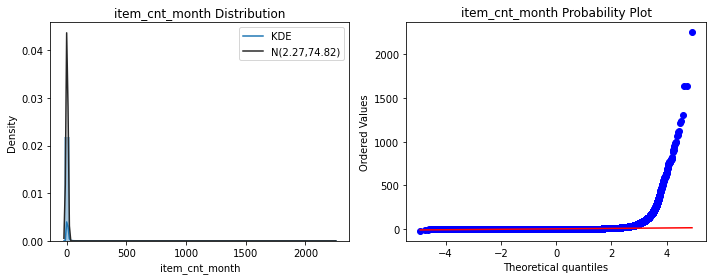

In [117]:
QQ_plot(result['item_cnt_month'], 'item_cnt_month')

In [118]:
#Outlier 처리 
for col in ['item_cnt_month']: # 상관관계 분석결과 need outlier handing features
    #p01 = df_prep_train[col].quantile(0.01) 
    plow = 0
    p99 = result[col].quantile(0.99) 

    print(f'plow: {plow}, p99: {p99}')
    result[f'{col}']   = df_prep_train[col].clip(plow, p99) # assign Train quantile value

plow: 0, p99: 17.0


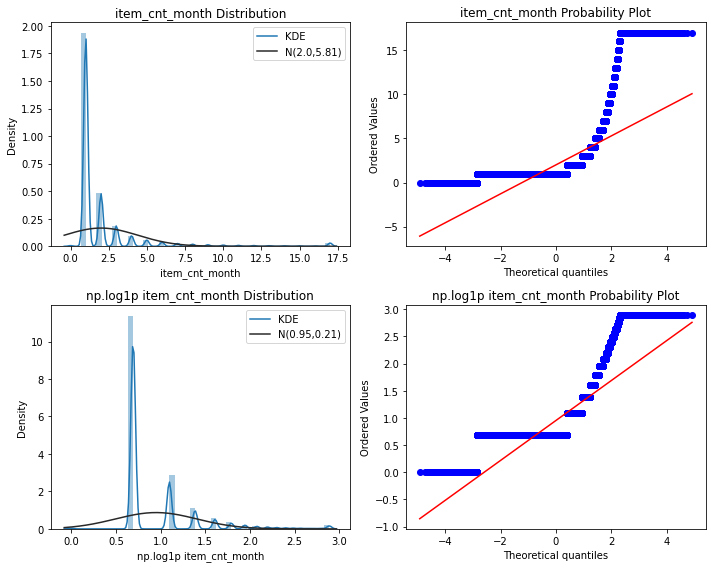

In [119]:
QQ_plot(result['item_cnt_month'], 'item_cnt_month', True)

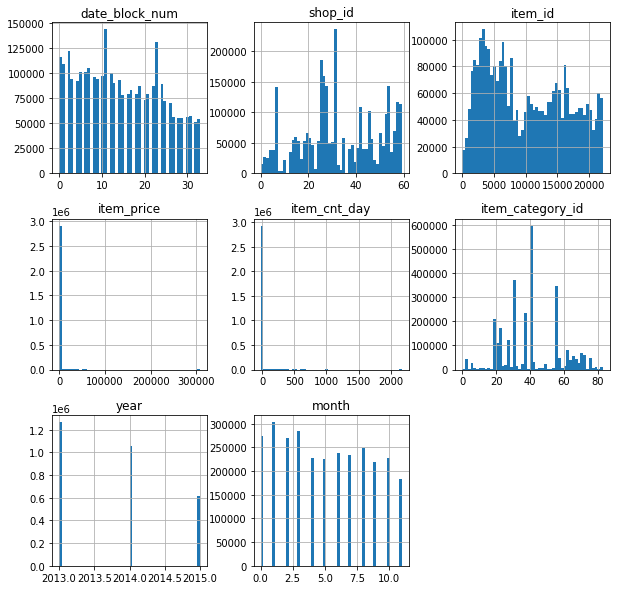

CPU times: user 2.01 s, sys: 145 ms, total: 2.15 s
Wall time: 2.03 s


In [27]:
%%time
%matplotlib inline
df_eda.hist(bins=50, figsize=(10,10))
plt.show()

In [28]:
# %%time
# sns.set(font_scale=1)
# plt.figure(figsize=(10,10))
# #sns.heatmap(df_eda.drop('item_price',axis=1).corr(),cmap="BuPu",annot=True)
# sns.heatmap(df_eda.corr(),fmt='.1f',cmap="coolwarm",annot=True)
# plt.show()

### 77) df_eda 제거하기

In [29]:
del df_eda
del df_eda_test

<div id = 2 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
4. 데이터 전처리(Data Preprecessing)
</h2>
</div>

### 4.1 전처리용 데이터 준비하기

In [30]:
# 모델 성능 그래프 Label 정보 활용 
trynum = 0

In [31]:
# 그래프 초기화
utils.clear_error()

In [120]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_prep_train = df_train_raw.copy()
df_prep_predict = df_test.copy()

In [121]:
# 작업 명세서 초기화
change_work = ''

### 4.3 shop/itemid/연/월 기준 summary Feature 생성

In [122]:
# year
df_prep_train['year'] = df_prep_train['date'].apply(lambda x : int(x.split('.')[2]))
# month
df_prep_train['month'] = df_prep_train['date_block_num'].apply(lambda x : (x +1) % 12)

df_prep_train = df_prep_train.groupby(['shop_id','item_id','year','month'])[['item_cnt_day']].sum()
df_prep_train = df_prep_train.reset_index()
df_prep_train.rename(columns = {'item_cnt_day' : 'item_cnt_month'}, inplace = True)
df_prep_train

,shop_id,item_id,year,month,item_cnt_month
0,0,30,2013,2,31.0
1,0,31,2013,2,11.0
2,0,32,2013,1,6.0
3,0,32,2013,2,10.0
4,0,33,2013,1,3.0
...,...,...,...,...,...
1609119,59,22164,2015,4,2.0
1609120,59,22164,2015,7,1.0
1609121,59,22167,2013,0,2.0
1609122,59,22167,2013,10,1.0


In [123]:
df_prep_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   shop_id         1609124 non-null  int64  
 1   item_id         1609124 non-null  int64  
 2   year            1609124 non-null  int64  
 3   month           1609124 non-null  int64  
 4   item_cnt_month  1609124 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 61.4 MB


In [124]:
df_prep_train.columns

Index(['shop_id', 'item_id', 'year', 'month', 'item_cnt_month'], dtype='object')

In [125]:
# year
df_prep_predict['year'] = 2015
# month
df_prep_predict['month'] = 11
df_prep_predict

,ID,shop_id,item_id,year,month
0,0,5,5037,2015,11
1,1,5,5320,2015,11
2,2,5,5233,2015,11
3,3,5,5232,2015,11
4,4,5,5268,2015,11
...,...,...,...,...,...
214195,214195,45,18454,2015,11
214196,214196,45,16188,2015,11
214197,214197,45,15757,2015,11
214198,214198,45,19648,2015,11


In [126]:
df_prep_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
 3   year     214200 non-null  int64
 4   month    214200 non-null  int64
dtypes: int64(5)
memory usage: 8.2 MB


## 4.7 Outlier

### 1) Train Data 처리

In [127]:
change_work += 'outlier in train,'
#Outlier 처리 
for col in ['item_cnt_month']: # 상관관계 분석결과 need outlier handing features
    #p01 = df_prep_train[col].quantile(0.01) 
    plow = 0
    p99 = df_prep_train[col].quantile(0.99) 

    print(f'plow: {plow}, p99: {p99}')
    df_prep_train[f'{col}']   = df_prep_train[col].clip(plow, p99) # assign Train quantile value

plow: 0, p99: 17.0


### 1-2) 예측값 지수함수처리 

In [128]:
change_work += 'np.log1p in train,'
df_prep_train['item_cnt_month'] = df_prep_train['item_cnt_month'].apply(lambda x : np.log1p(x))

## 4.8 데이타 표준화 처리

In [129]:
scaler = StandardScaler()

In [130]:
# 학습 데이터 각 변수의 평균값과 표준편차를 저장한 후, 이를 사용하여 학습 및 평가용 데이터를 변환
apply_column = ['shop_id', 'item_id', 'year', 'month']
# for dropfeature in dropfeatures: #  index와 predict feature 제외
#     if dropfeature in dropfeatures:
#         apply_column.remove(dropfeature)
# for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
#     if exceptfeature in apply_column:
#         apply_column.remove(exceptfeature)
# for outlier in col_need_outlier_handing_list: # need outlier handing feature 제외
#     if outlier in apply_column:
#         apply_column.remove(outlier)
change_work += 'stadardscaler in train,'
# Train data standardscale
df_prep_train[apply_column] = scaler.fit_transform(df_prep_train[apply_column])
change_work += 'stadardscaler in predict,'
# Predict data standardscale
df_prep_predict[apply_column] = scaler.fit_transform(df_prep_predict[apply_column])

In [131]:
sp.mean(df_prep_train[apply_column], axis=0).head(3).round(3), sp.std(df_prep_predict[apply_column], axis=0).head(3).round(3)

(shop_id    0.0
 item_id   -0.0
 year       0.0
 dtype: float64,
 shop_id    1.0
 item_id    1.0
 year       0.0
 dtype: float64)

<div id = 2 style="color:white;    
           display:fill;
           border-radius:10px;
           background-color:blue;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
          color:white;
          text-align:left;
          margin:0 auto;
          ">
5. 모델링(Modeling)
</h2>
</div>

### 5.1 모델 성능 평가함수 정의

In [132]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true, y_pred):
  return round(mean_squared_error(y_true, y_pred, squared=False), 4)

### 5.2 모델 공통 정보 설정

In [133]:
MODEL_SEED = 123

In [134]:
TEST_SIZE = 0.15
# result message
change_work += 'SEED=123,TEST_SIZE=0.15,'
# change_work += 'SEED=123,TEST_SIZE=0.1,'

### 5.3 모델구축

#### 5.4.1 Ridge 회귀모델

##### 5.4.1.1 데이타 분할

In [135]:
# result message
# change_work += 'Ridge : 컬럼선별:corr >= |0.5|,'
# change_work += 'Ridge : ALL,'
change_work += 'Ridge : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
# col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
#         + col_result_outlier_list # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
# for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
#     if exceptfeature in col_X :
#         col_X.remove(exceptfeature)
# for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
#     if outlierfeature in col_X :
#         col_X.remove(outlierfeature)
# for dropfeature in dropfeatures: #  index와 predict feature 제외
#     if dropfeature in col_X :
#         col_X.remove(dropfeature)
# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
# col_X = list(select_cols)
col_X = ['shop_id', 'item_id', 'year', 'month']
col_y = 'item_cnt_month'
print(col_X)
print(f'Ridge Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
x_ridge_train_raw = df_prep_train[col_X]
y_ridge_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
x_ridge_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
x_ridge_train, x_ridge_valid, y_ridge_train, y_ridge_valid = train_test_split(x_ridge_train_raw, y_ridge_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['shop_id', 'item_id', 'year', 'month']
Ridge Feature 수 : 4


##### 5.4.1.2 Ridge 회귀모델

In [136]:
%%time

# change_work += 'ridge  range(170, 210, 5)'
change_work += ' ridge np.logspace(-2,1,10)'

# log 단위(1e+01)로 1.e-02 ~ 1.e+01 구간에 대해 매개변수를 탐색합니다.
ridge_params = {
    'alpha': np.logspace(-2,1,10),
#     'alpha': range(170, 210, 5),
    'random_state' : [MODEL_SEED]
}

CPU times: user 250 µs, sys: 0 ns, total: 250 µs
Wall time: 256 µs


In [137]:
%%time

# GridSearchCV를 이용하여 Ridge 모델을 저장합니다.
ridge_model = GridSearchCV(Ridge(), param_grid=ridge_params, refit=True, scoring='neg_root_mean_squared_error')
ridge_model.fit(x_ridge_train, y_ridge_train)

CPU times: user 8.68 s, sys: 4.2 s, total: 12.9 s
Wall time: 7.87 s


GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                         'random_state': [123]},
             scoring='neg_root_mean_squared_error')

In [138]:
col_cv_results = ['params', 'mean_test_score', 'rank_test_score']
pd.DataFrame(ridge_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'alpha': 0.01, 'random_state': 123}",-0.455102,10
1,"{'alpha': 0.021544346900318832, 'random_state': 123}",-0.455102,9
2,"{'alpha': 0.046415888336127774, 'random_state': 123}",-0.455102,8
3,"{'alpha': 0.1, 'random_state': 123}",-0.455102,7
4,"{'alpha': 0.21544346900318834, 'random_state': 123}",-0.455102,6
5,"{'alpha': 0.46415888336127775, 'random_state': 123}",-0.455102,5
6,"{'alpha': 1.0, 'random_state': 123}",-0.455102,4
7,"{'alpha': 2.154434690031882, 'random_state': 123}",-0.455102,3
8,"{'alpha': 4.6415888336127775, 'random_state': 123}",-0.455102,2
9,"{'alpha': 10.0, 'random_state': 123}",-0.455102,1


In [139]:
print(ridge_model.best_params_)

{'alpha': 10.0, 'random_state': 123}


### 5.4.2 Random Forest 모델

#### 5.4.2.1 데이타 분할

In [140]:
# result message
# change_work += 'Rf : All,'
# change_work += 'Rf : outlierfeature remove, '
# change_work += 'Rf : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
# col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
#         + col_result_outlier_list # outlier 처리 결과 리스트를 추가하기
# for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
#     if exceptfeature in col_X :
#         col_X.remove(exceptfeature)
# for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
#     if outlierfeature in col_X :
#         col_X.remove(outlierfeature)
# for dropfeature in dropfeatures: #  index와 predict feature 제외
#     if dropfeature in col_X :
#         col_X.remove(dropfeature)
col_X = ['shop_id', 'item_id', 'year', 'month']
col_y = 'item_cnt_month'

print(col_X)
print(f'RF Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
# x_rf_train_raw = df_prep_train[col_X]
# y_rf_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
# x_rf_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
# x_rf_train, x_rf_valid, y_rf_train, y_rf_valid = train_test_split(x_rf_train_raw, y_rf_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['shop_id', 'item_id', 'year', 'month']
RF Feature 수 : 4


#### 5.4.2.2 Random Forest 모델

In [141]:
%%time

change_work += 'Rf : param : [500],[4] '

rf_params = {'n_estimators': [500],
             'min_samples_split' : [2],
             'min_samples_leaf' : [1],
             'max_features' : [4],
             'random_state' : [MODEL_SEED]
} 

# GridSearchCV를 이용하여 Randomforest 모델을 저장합니다.
# rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_root_mean_squared_error')
# rf_model.fit(x_rf_train, y_rf_train)

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 11 µs


In [142]:
# pd.DataFrame(rf_model.cv_results_)[col_cv_results]

In [143]:
# rf_model.best_params_

### 5.4.3 XGBoost 모델

#### 5.4.3.1 데이타 분할

In [144]:
# result message
change_work += 'XGB : All,'
# change_work += 'XGB : outlierfeature remove, '
# change_work += 'XGB : exceptfeature, outlierfeature remove, '

# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
# col_X = col_nona_numerical + col_hasna_numerical + col_nona_object + col_hasna_object + col_gen_flagfields + col_gen_datefields \
#         + col_result_outlier_list # outlier 처리 결과 리스트를 추가하기
# for exceptfeature in col_except_feature_list: # 상관관계 분석 결과 except feature list 제외
#     if exceptfeature in col_X :
#         col_X.remove(exceptfeature)
# for outlierfeature in col_need_outlier_handing_list: # outlier 필요 대상 list는 제외하고, 대신 처리 결가 리스트를 추가하기
#     if outlierfeature in col_X :
#         col_X.remove(outlierfeature)
# for dropfeature in dropfeatures: #  index와 predict feature 제외
#     if dropfeature in col_X :
#         col_X.remove(dropfeature)
col_X = ['shop_id', 'item_id', 'year', 'month']
col_y = 'item_cnt_month'


print(col_X)
print(f'XGB Feature 수 : { len(col_X) }')

# 학습용 데이터를 정의합니다.
x_xgb_train_raw = df_prep_train[col_X]
y_xgb_train_raw = df_prep_train[col_y]

# 평가용 데이터를 정의합니다.
x_xgb_predict = df_prep_predict[col_X]

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
SEED = 71
x_xgb_train, x_xgb_valid, y_xgb_train, y_xgb_valid = train_test_split(x_xgb_train_raw, y_xgb_train_raw, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

['shop_id', 'item_id', 'year', 'month']
XGB Feature 수 : 4


#### 5.4.3.2 XGBoost 모델

In [145]:
# change_work += 'XGB : param : [100,200],[0.1]  ' 
change_work += 'XGB : param : [700],[0.4]  ' 

# XGBoost 모델
xgb_params = {
    'n_estimators': [700],  
    'learning_rate' : [0.4], # default : 0.3 (0-1)
    'eval_metric': ['rmse'],
 #   'max_depth' : [4, 6, 8, 9], # default : 6
    'objective': ['reg:squarederror'] ,
    'random_state' : [MODEL_SEED]
} 

In [146]:
%%time

# GridSearchCV를 이용하여 XGBoost 모델을 저장합니다.
xgb_model = GridSearchCV(XGBRegressor(tree_method='gpu_hist', gpu_id=0), param_grid=xgb_params, cv=5, scoring='neg_root_mean_squared_error')

xgb_model.fit(x_xgb_train, y_xgb_train)

CPU times: user 5min 15s, sys: 2.05 s, total: 5min 17s
Wall time: 3min 38s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=0, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [147]:
pd.DataFrame(xgb_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'eval_metric': 'rmse', 'learning_rate': 0.3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'random_state': 123}",-0.408998,9
1,"{'eval_metric': 'rmse', 'learning_rate': 0.3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'random_state': 123}",-0.407229,6
2,"{'eval_metric': 'rmse', 'learning_rate': 0.3, 'n_estimators': 700, 'objective': 'reg:squarederror', 'random_state': 123}",-0.406537,2
3,"{'eval_metric': 'rmse', 'learning_rate': 0.4, 'n_estimators': 300, 'objective': 'reg:squarederror', 'random_state': 123}",-0.407996,8
4,"{'eval_metric': 'rmse', 'learning_rate': 0.4, 'n_estimators': 500, 'objective': 'reg:squarederror', 'random_state': 123}",-0.406709,3
5,"{'eval_metric': 'rmse', 'learning_rate': 0.4, 'n_estimators': 700, 'objective': 'reg:squarederror', 'random_state': 123}",-0.406450,1
6,"{'eval_metric': 'rmse', 'learning_rate': 0.5, 'n_estimators': 300, 'objective': 'reg:squarederror', 'random_state': 123}",-0.407753,7
7,"{'eval_metric': 'rmse', 'learning_rate': 0.5, 'n_estimators': 500, 'objective': 'reg:squarederror', 'random_state': 123}",-0.406917,5
8,"{'eval_metric': 'rmse', 'learning_rate': 0.5, 'n_estimators': 700, 'objective': 'reg:squarederror', 'random_state': 123}",-0.406835,4


In [148]:
xgb_model.best_params_

{'eval_metric': 'rmse',
 'learning_rate': 0.4,
 'n_estimators': 700,
 'objective': 'reg:squarederror',
 'random_state': 123}

### 5.5 최종모델 구축

In [149]:
# 최적의 하이퍼파라미터로 학습된 릿지 회귀 모델을 저장합니다. 
best_ridge = ridge_model.best_estimator_

# # 최적의 하이퍼파라미터로 학습된 랜덤포레스트 모델을 저장합니다. 
# best_rf = rf_model.best_estimator_

# # 최적의 하이퍼파라미터로 학습된 XGBoost 모델을 저장합니다.  
best_xgb = xgb_model.best_estimator_

# 학습용 데이터셋의 타깃 변수 예측 
y_pred_tr_ridge = best_ridge.predict(x_ridge_train)
# y_pred_tr_rf = best_rf.predict(x_rf_train)
y_pred_tr_xgb = best_xgb.predict(x_xgb_train)

# 검증용 데이터셋의 타깃 변수 예측 
y_pred_va_ridge = best_ridge.predict(x_ridge_valid)
# y_pred_va_rf = best_rf.predict(x_rf_valid)
y_pred_va_xgb = best_xgb.predict(x_xgb_valid)

# 평가용 데이터셋의 타깃 변수 예측 
y_pred_te_ridge = best_ridge.predict(x_ridge_predict)
# y_pred_te_rf = best_rf.predict(x_rf_predict)
y_pred_te_xgb = best_xgb.predict(x_xgb_predict)

# 앙상블 모형의 학습 및 검증 데이터에 대한 타깃 변수 예측 
# y_pred_tr_en= np.mean([y_pred_tr_ridge, y_pred_tr_xgb], axis=0)
# y_pred_va_en= np.mean([y_pred_va_ridge, y_pred_va_xgb], axis=0)
# y_pred_te_en= np.mean([y_pred_te_ridge, y_pred_te_xgb], axis=0)
# y_pred_tr_en1= np.mean([y_pred_tr_ridge, y_pred_tr_rf], axis=0)
# y_pred_va_en1= np.mean([y_pred_va_ridge, y_pred_va_rf], axis=0)
# y_pred_te_en1= np.mean([y_pred_te_ridge, y_pred_te_rf], axis=0)

# print(f'en  : y_pred_tr_ridge, y_pred_tr_xgb')
# print(f'en1 : y_pred_tr_ridge, y_pred_tr_rf')

# ensenble 모델 처리 함수  : 0.5, 0.5
#change_work += 'Combined_model : ridge * 0.4 + xgb * 0.6 ' 
# change_work += 'Combined_model : ridge * 0.6 + xgb * 0.4 ' 
change_work += 'Combined_model : ridge * 0.5 + xgb * 0.5 ' 
def combined_models(rx, xgbx):
    return ((0.5 * best_ridge.predict(rx)) + 
            (0.5 * best_xgb.predict(xgbx)) 
           )
y_pred_tr_en= combined_models(x_ridge_train  , x_xgb_train)
y_pred_va_en= combined_models(x_ridge_valid  , x_xgb_valid)
y_pred_te_en= combined_models(x_ridge_predict, x_xgb_predict)

# ensenble 모델 처리 함수  : 0.5, 0.1, 0.4  => 0.12762
# def combined_models(rx, rfx, xgbx):
#     return ((0.5 * best_ridge.predict(rx)) + 
#             (0.0 * best_rf.predict(rfx)) + 
#             (0.5 * best_xgb.predict(xgbx)) 
#            )
# y_pred_tr_en= combined_models(x_ridge_train  , x_rf_train  , x_xgb_train)
# y_pred_va_en= combined_models(x_ridge_valid  , x_rf_valid  , x_xgb_valid)
# y_pred_te_en= combined_models(x_ridge_predict, x_rf_predict, x_xgb_predict)

# def combined_models(rx, rfx, xgbx, stackx):
#     return ((0.40 * best_ridge.predict(rx)) + 
#             (0.05 * best_rf.predict(rfx)) + 
#             (0.05 * best_xgb.predict(xgbx)) +
#             (0.50 * stack.predict(np.array(stackx)))
#            )
# y_pred_tr_en= combined_models(x_ridge_train  , x_rf_train  , x_xgb_train, x_stack_train)
# y_pred_va_en= combined_models(x_ridge_valid  , x_rf_valid  , x_xgb_valid, x_stack_valid)
# y_pred_te_en= combined_models(x_ridge_predict, x_rf_predict, x_xgb_predict, x_stack_predict)


In [150]:
# 학습 데이터셋의 RMSE 계산 
rmse_tr_ridge = rmse(y_ridge_train, y_pred_tr_ridge)
# rmse_tr_rf = rmse(y_rf_train, y_pred_tr_rf)
rmse_tr_xgb = rmse(y_xgb_train, y_pred_tr_xgb)
rmse_tr_en = rmse(y_ridge_train, y_pred_tr_en)
# rmse_tr_en1 = rmse(y_rf_train, y_pred_tr_en1)

# 검증 데이터셋의 RMSE 계산 
rmse_va_ridge = rmse(y_ridge_valid, y_pred_va_ridge)
# rmse_va_rf = rmse(y_rf_valid, y_pred_va_rf)
rmse_va_xgb = rmse(y_xgb_valid, y_pred_va_xgb)
rmse_va_en = rmse(y_ridge_valid, y_pred_va_en)
# rmse_va_en1 = rmse(y_rf_valid, y_pred_va_en1)

# 검증 결과 Result DataFrame 저장
trynum = trynum + 1
index_name = list(str(trynum))
data = {
    'Work'                : [change_work],
    'RIDGE Train RSME'    : [round(rmse_tr_ridge, 4)], 
    'RIDGE valid RSME'    : [round(rmse_va_ridge, 4)],
    'XGB Train RSME'      : [round(rmse_tr_xgb, 4)], 
    'XGB valid RSME'      : [round(rmse_va_xgb, 4)],
    'RIDGE+XGB Train RSME': [round(rmse_tr_en, 4)], 
    'RIDGE+XGB valid RSME': [round(rmse_va_en, 4)]
}
# data = {
#     'Work'                : [change_work],
#     'RIDGE Train RSME'    : [round(rmse_tr_ridge, 4)], 
#     'RIDGE valid RSME'    : [round(rmse_va_ridge, 4)],
#     'RF Train RSME'       : [round(rmse_tr_rf, 4)], 
#     'RF valid RSME'       : [round(rmse_va_rf, 4)],
#     'XGB Train RSME'      : [round(rmse_tr_xgb, 4)], 
#     'XGB valid RSME'      : [round(rmse_va_xgb, 4)],
#     'RIDGE+XGB Train RSME': [round(rmse_tr_en, 4)], 
#     'RIDGE+XGB valid RSME': [round(rmse_va_en, 4)],
#     'RIDGE+RF Train RSME' : [round(rmse_tr_en1, 4)], 
#     'RIDGE+RF valid RSME' : [round(rmse_va_en1, 4)]
# }
df_tmp = pd.DataFrame(data, index = index_name)
df_results = pd.concat([df_results, df_tmp])
del df_tmp

In [151]:
df_results

,Work,RIDGE Train RSME,RIDGE valid RSME,XGB Train RSME,XGB valid RSME,RIDGE+XGB Train RSME,RIDGE+XGB valid RSME
1,"outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : param : [500],[4] XGB : All,XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5",2.4008,2.4022,2.1175,2.1419,2.2034,2.2163
2,"outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : param : [500],[4] XGB : All,XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5 XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5",2.4008,2.4022,2.0991,2.1342,2.1890,2.2072
3,"outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,outlier in train,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : param : [500],[4] XGB : All,XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5 XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5 XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5",2.4008,2.4022,2.0974,2.1335,2.1886,2.2073
4,"outlier in train,np.log1p in train,stadardscaler in train,stadardscaler in predict,SEED=123,TEST_SIZE=0.15,Ridge : exceptfeature, outlierfeature remove, ridge np.logspace(-2,1,10)Rf : param : [500],[4] XGB : All,XGB : param : [200, 300],[0.2, 0.3, 0.4] Combined_model : ridge * 0.5 + xgb * 0.5",0.4551,0.4553,0.3977,0.4052,0.4145,0.4183


### 5.6 검증용 데이터로 성능 비교

(0.0, 5.0)

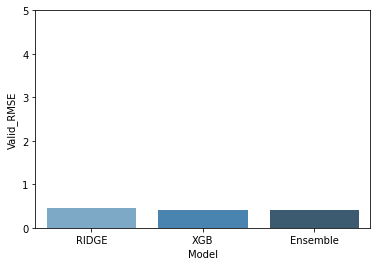

In [152]:
# rmse_valid = [rmse_va_ridge, rmse_va_rf, rmse_va_xgb, rmse_va_en]
# recap_model = ['RIDGE', 'RF', 'XGB', 'Ensemble']
rmse_valid = [rmse_va_ridge, rmse_va_xgb, rmse_va_en]
recap_model = ['RIDGE', 'XGB', 'Ensemble']
df_recap = pd.DataFrame({'Model': recap_model, 'Valid_RMSE' : rmse_valid})
ax = sns.barplot(x='Model', y='Valid_RMSE', data=df_recap, palette="Blues_d")
ax.set_ylim([0, 5]) 

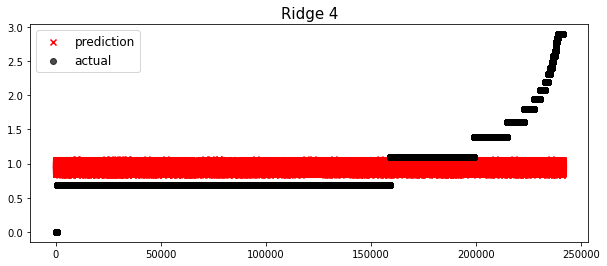

,model,error
0,Ridge 1,2.402220
1,Ridge 2,2.402220
2,Ridge 3,2.402220
3,Ensenble 1,2.216329
4,Ensenble 3,2.207326
5,Ensenble 2,2.207192
6,Ridge 4,0.455298


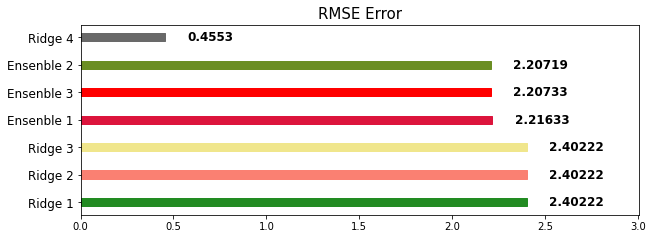

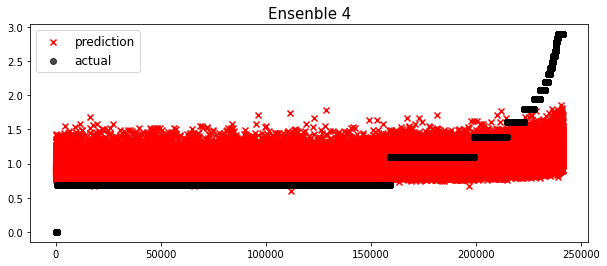

,model,error
0,Ridge 1,2.402220
1,Ridge 2,2.402220
2,Ridge 3,2.402220
3,Ensenble 1,2.216329
4,Ensenble 3,2.207326
5,Ensenble 2,2.207192
6,Ridge 4,0.455298
7,Ensenble 4,0.418348


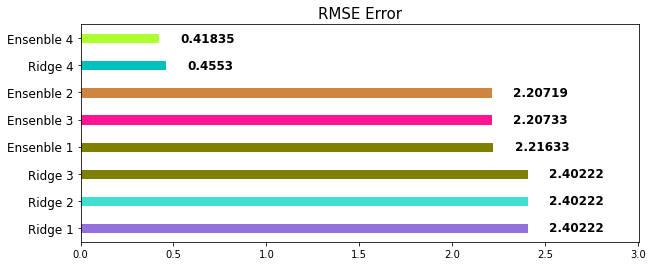

In [153]:
utils.plot_error('Ridge '+ str(trynum), y_ridge_valid, y_pred_va_ridge)
utils.plot_error('Ensenble ' + str(trynum), y_ridge_valid, y_pred_va_en)

### 6.1 예측값 저장하기

In [154]:
df_prep_predict['item_cnt_month'] = list(np.expm1(y_pred_te_en))
df_submission = df_prep_predict[['ID', 'item_cnt_month']] 
df_submission.head()

,ID,item_cnt_month
0,0,1.448398
1,1,1.620444
2,2,1.621298
3,3,1.621308
4,4,1.620954


In [155]:
# 월별 건수를 반올림 정수 보정하기
df_submission['item_cnt_month'] = df_submission['item_cnt_month'].apply(lambda x : int(np.round(x)))

In [156]:
df_submission.head()

,ID,item_cnt_month
0,0,1
1,1,2
2,2,2
3,3,2
4,4,2


In [157]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

ID                0
item_cnt_month    0
dtype: int64

In [158]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(df_prep_predict)
print(f'No. of Predict DataSet : {len(df_prep_predict)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 214200
No. of Submission DataSet : 214200


### 6.3 결과파일 저장하기

In [159]:
# 예측 파일을 저장합니다. 
df_submission.set_index('ID', inplace=True)
df_submission.to_csv(f'submission.csv')